In [1]:
!pip install tf-nightly-gpu-2.0-preview tfp-nightly
!pip install -q pydot
!apt-get install graphviz
!pip install keras-tqdm

zsh:1: command not found: pip
zsh:1: command not found: pip
zsh:1: command not found: apt-get
zsh:1: command not found: pip


In [2]:
# plotting inline
%matplotlib inline

# importing necessary modules
import keras
import random
import numpy as np
import pandas as pd
import scipy.stats as sp
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, concatenate, Input, Embedding
from tensorflow.keras.layers import Reshape, Concatenate, BatchNormalization, Dropout, Add, Lambda
from tensorflow.keras.layers import add
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.ensemble import BaggingRegressor
from copy import deepcopy
from keras_tqdm import TQDMNotebookCallback

# turning off automatic plot showing, and setting style
plt.ioff()
plt.style.use('bmh')

# Risk and Uncertainty in Deep Learning

Neural networks have been pushing what is possible in a lot of domains and are becoming a standard tool in industry. As they start being a vital part of business decision making, methods that try to open the neural network "black box" are becoming increasingly popular. [LIME](https://github.com/marcotcr/lime), [SHAP](https://github.com/slundberg/shap) and [Embeddings](https://distill.pub/2019/activation-atlas/) are nice ways to explain what the model learned and why it makes the decisions it makes. On the other hand, instead of trying to explain what the model learned, we can also try to get insights about what the model **does not know**, which implies estimating two different quantities: **risk** and **uncertainty**. [Variational Inference](https://arxiv.org/abs/1505.05424), [Monte Carlo Dropout](https://arxiv.org/abs/1506.02142) and [Bootstrapped Ensembles](https://arxiv.org/abs/1602.04621) are some examples of research in this area. 

At first glance, risk and uncertainty may seem to be the same thing, but in reality they are, in some cases, orthogonal concepts. **Risk** stands for the intrinsic volatility over the outcome of a decision: when we roll a dice, for instance, we always **risk** getting a bad outcome, even if we precisely know the possible outcomes. **Uncertainty**, on the other hand, stands for the confusion about what the possible outcomes are: if someone gives us a strange dice we have never used before, we'll have to roll it for a while before we can even **know** what to expect about its outcomes. Risk is a fixed property of our problem, which can't be cleared by collecting more data, while uncertainty is a property of our beliefs, and can be cleared with more data. Actually we can have **uncertainty** over our belief of what the **risk** actually is! 

If this seems strange at first, don't worry: this topic has been the object of [heated discussions](https://twitter.com/ianosband/status/1014466510885216256) among experts in the area recently. The main question is if a given model estimates the **risk** (*aleatoric uncertainty*) or **uncertainty** (*epistemic uncertainty*). Some references make this discussion very interesting. I put some of them at the end of the post, for your reference. 

In our case, we'll focus on a simple example to illustrate the how the concepts are different and how to use a neural network to estimate them at the same time.

# Why is this relevant?

Risk measures the volatility in making a decision, while uncertainty measures the condifence in our belief about this volatility. Both measures are essential for decision making, particularly in decisions that put a lot of resources at stake. For instance, suppose you use a model to sell your house. A model with a good risk estimate will tell you the volatility in closing price given a specified tolerance of days on-market. Then, a model with a good uncertainty estimate will tell you how your closing price volatility estimate is reliable, given the amount of data you have. In this post, we'll simulate a synthetic case for you to understand and run a model that can do both estimates at the same time. 


# 1. Data

We'll use the same data generating process of my [last post](https://gdmarmerola.github.io/intro-randomized-prior-functions/), borrowed from [Blundell et. al (2015)](https://arxiv.org/pdf/1505.05424.pdf). I add some heteroskedastic noise and use a gaussian distribution to generate $X$, so that risk and uncertainty are bigger when we get far from the origin. The process will look like this:

$$ y = x + 0.3 \cdot{} sin(2π(x + \epsilon)) + 0.3 \cdot{} sin(4 \cdot{} \pi \cdot{}(x + \epsilon)) + \epsilon$$

where $\epsilon \sim \mathcal{N}(0, 0.01 + 0.1 \cdot x^2)$ and $x \sim N(0.0,1.0)$:

In [3]:
# setting seed 
np.random.seed(10)

# generating big and small datasets
X = np.clip(np.random.normal(0.0, 1.0, 1000).reshape(-1,1), -3, 3)

# let us generate a grid to check how models fit the data
x_grid = np.linspace(-5, 5, 1000).reshape(-1,1)

# defining the function - noisy
noise = lambda x: sp.norm(0.00, 0.01 + (x**2)/10)
target_toy = lambda x: (x + 0.3*np.sin(2*np.pi*(x + noise(x).rvs(1)[0])) + 
                        0.3*np.sin(4*np.pi*(x + noise(x).rvs(1)[0])) + 
                        noise(x).rvs(1)[0] - 0.5)

# defining the function - no noise
target_toy_noiseless = lambda x: (x + 0.3*np.sin(2*np.pi*(x)) + 0.3*np.sin(4*np.pi*(x)) - 0.5)

# runnning the target
y = np.array([target_toy(e) for e in X])
y_noiseless = np.array([target_toy_noiseless(e) for e in x_grid])

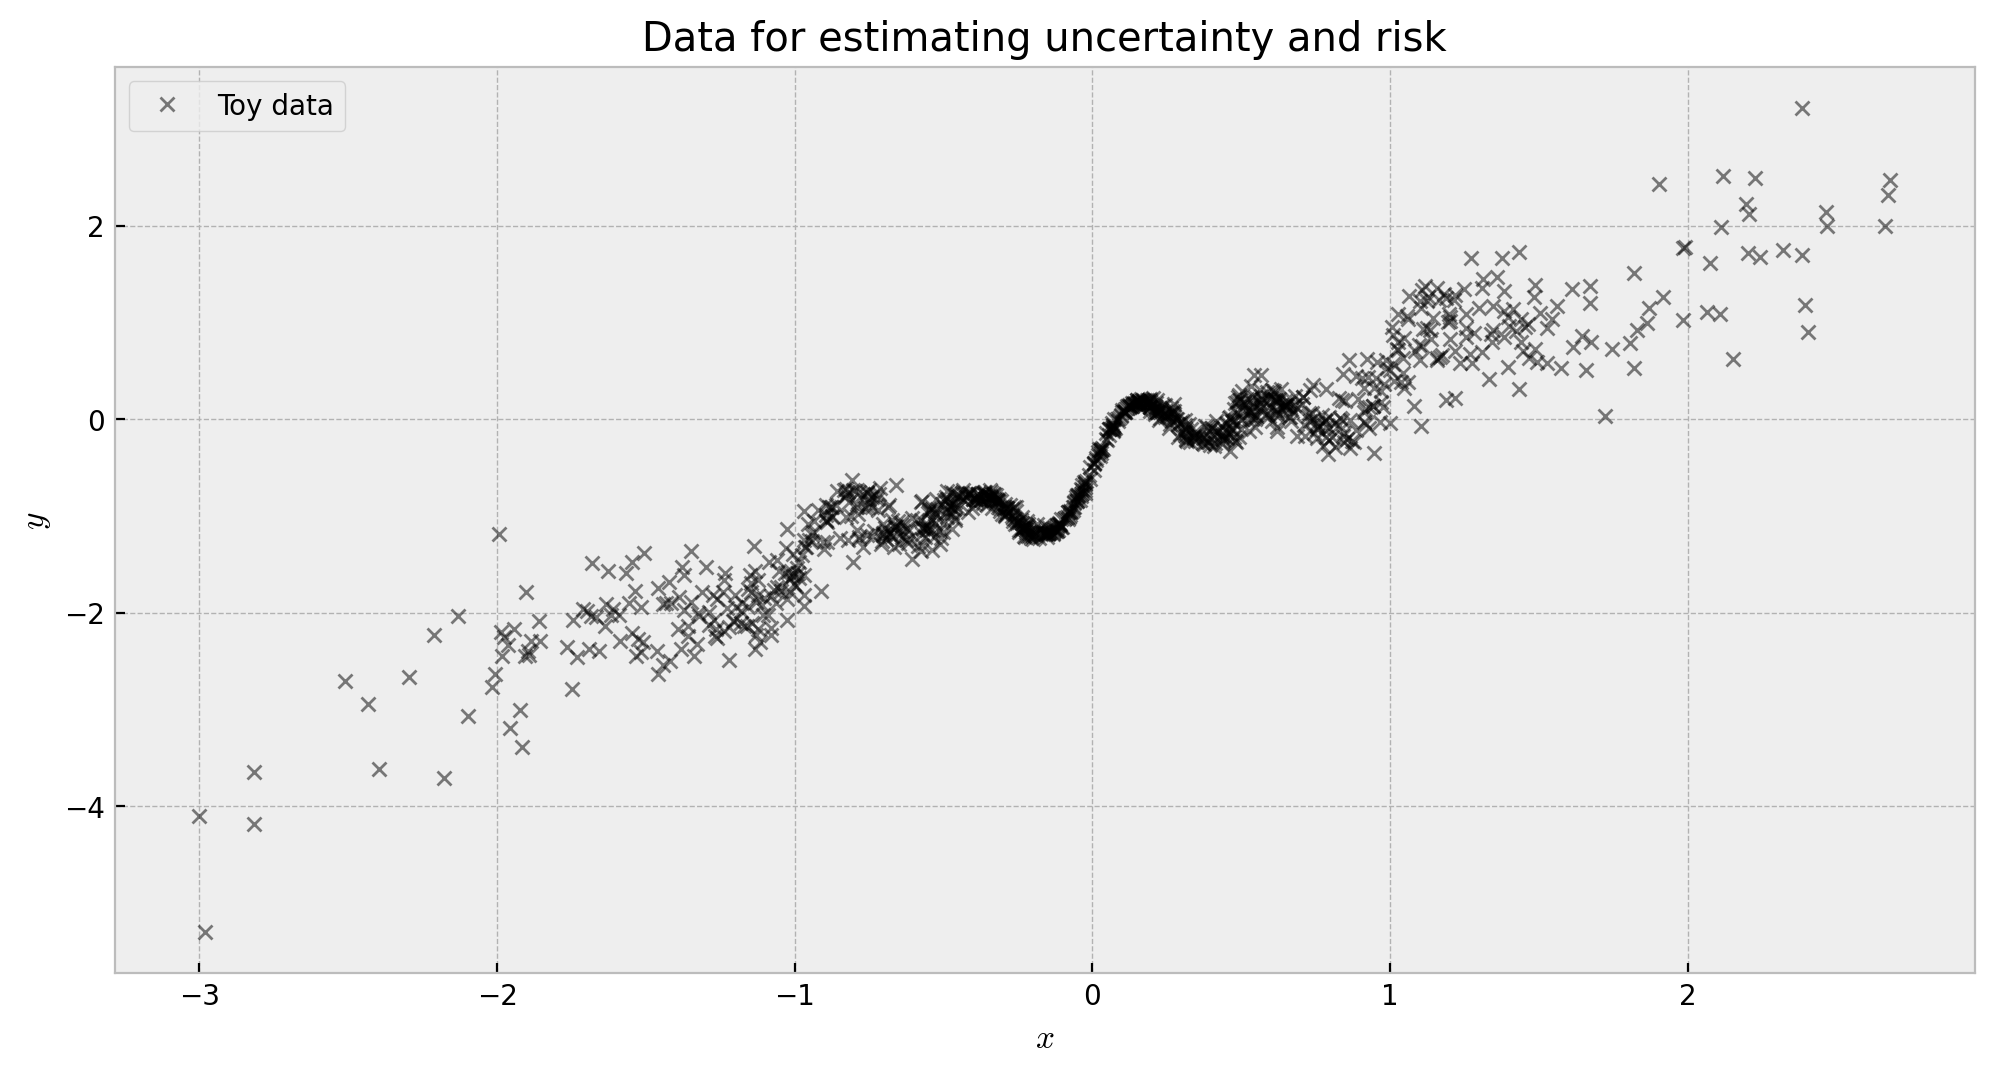

In [4]:
# let us check the toy data
plt.figure(figsize=[12,6], dpi=200)

# first plot
plt.plot(X, y, 'kx', label='Toy data', alpha=0.5, markersize=5)
#plt.plot(x_grid, y_noiseless, 'r--')
plt.title('Data for estimating uncertainty and risk')
plt.xlabel('$x$'); plt.ylabel('$y$')
plt.legend();
plt.show()

This problem is good for measuring both risk and uncertainty. Risk gets bigger where the intrinsic noise from the data generating process is larger, which in this case is away from the origin, due to our choice of $\epsilon \sim \mathcal{N}(0, 0.01 + 0.1 \cdot x^2)$. Uncertainty gets bigger where there's less data, which is also away from the origin, due to the distribution of $x$ being a normal  $x \sim N(0.0,1.0)$. 

So, let us start to build a risk and uncertainty estimating model for this data! The first step is to use a vanilla neural network to estimate expected values.

# 2. Expected values with regular neural network

Let us start with the simplest model: a vanilla neural network. Below, we build the `get_regular_nn` function to tidy up the compilation of the model. Warming up for the next challenge of estimating risk, we use `mean_absolute_error` as the loss function, which will try estimating the median expected value at each $x$.

In [ ]:
# function to get a randomized prior functions model
def get_regular_nn():

    # shared input of the network
    net_input = Input(shape=(1,), name='input')

    # trainable network body
    trainable_net = Sequential([Dense(16, 'elu'),
                                Dense(16, 'elu'),
                                Dense(16, 'elu')], 
                               name='layers')(net_input)
    
    # trainable network output
    trainable_output = Dense(1, activation='linear', name='output')(trainable_net)

    # defining the model and compiling it
    model = Model(inputs=net_input, outputs=trainable_output)
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_squared_error'])
    
    # returning the model 
    return model

Cool, the model is implemented thorugh `get_regular_nn`. We then build a model by calling it and fitting it to our data:

In [ ]:
# generating the model
regular_nn = get_regular_nn();

# fitting the model
regular_nn.fit(X, y, batch_size=16, epochs=500, verbose=0)

We show the fit below. It's close to what we would imagine a regular neural network fit would be for this data:

In [ ]:
# let us check the toy data
plt.figure(figsize=[12,6], dpi=200)

# first plot
plt.plot(X, y, 'kx', label='Toy data', alpha=0.5, markersize=5)
plt.plot(x_grid, regular_nn.predict(x_grid), label='neural net fit', color='tomato', alpha=0.8)
plt.title('Neural network fit for median expected value')
plt.xlabel('$x$'); plt.ylabel('$y$')
plt.xlim(-3.5,3.5); plt.ylim(-5, 3)
plt.legend();
plt.show()

The fit is reasonable, but there's a lot to improve yet. First, let us add the capacity of estimating **risk** to the network!

# 3. Risk with quantile regression

We add risk to our model by making the network perform quantile regression. Specifically, we will implement in `get_quantile_reg_nn` a network to estimate the median (50th percentile), the 10th and 90th percentile. The quantiles will give us the sense of volatility we want, and will be our proxy of risk. It is not hard to do that: we just have to change the objective function from L2 loss (mean squared error) to L1 loss (mean absolute error) for the median, and use the [quantile loss](https://heartbeat.fritz.ai/5-regression-loss-functions-all-machine-learners-should-know-4fb140e9d4b0) for the 10th and 90th percentiles. I heavily used [Deep Quantile Regression](https://towardsdatascience.com/deep-quantile-regression-c85481548b5a) by Sachin Abeywardana as inpiration, and I really recommend the read!

First, we implement the quantile (tilted) loss in Keras language and build loss functions for the 10th, 50th and 90th percentile:

In [ ]:
# implementing the tilted (quantile) loss
import tensorflow.keras.backend as K
def tilted_loss(q,y,f):
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)

# losses for 10th, 50th and 90th percentile
loss_10th_p = lambda y,f: tilted_loss(0.10,y,f)
loss_50th_p = lambda y,f: tilted_loss(0.50,y,f)
loss_90th_p = lambda y,f: tilted_loss(0.90,y,f)

Then, we build the function `get_quantile_reg_nn` to generate our model. The model is a multi-head MLP with one output (and corresponding loss function) for each percentile. We have a shared network `trainable_net`, which connects to three heads `output_xxth_p`, which will output the corresponding quantiles.

In [ ]:
# function to get a randomized prior functions model
def get_quantile_reg_nn():

    # shared input of the network
    net_input = Input(shape=(1,), name='input')

    # trainable network body
    trainable_net = Sequential([Dense(16, 'elu'),
                                Dense(16, 'elu'),
                                Dense(16, 'elu')], 
                               name='shared')(net_input)
    
    # trainable network output
    output_10th_p = Sequential([Dense(8, activation='elu'), 
                                Dense(1, activation='linear')],
                               name='output_10th_p')(trainable_net)
    output_50th_p = Sequential([Dense(8, activation='elu'), 
                                Dense(1, activation='linear')],
                               name='output_50th_p')(trainable_net)
    output_90th_p = Sequential([Dense(8, activation='elu'), 
                                Dense(1, activation='linear')],
                               name='output_90th_p')(trainable_net)
    
    # defining the model and compiling it
    model = Model(inputs=net_input, outputs=[output_10th_p, output_50th_p, output_90th_p])
    model.compile(loss=[loss_10th_p, loss_50th_p, loss_90th_p], optimizer='adam')
    
    # returning the model 
    return model

We can see the multi-output architecture in the following diagram:

In [ ]:
# checking final architecture
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(get_quantile_reg_nn()).create(prog='dot', format='svg'))

![](http://)We then proceed to fit the model. Note that we need (at least I don't know any workarounds) to duplicate our target and pass one copy of $y$ to each of the heads of the network, hence `[y]*3` in the `.fit()` method.

In [ ]:
# generating the model
quantile_nn = get_quantile_reg_nn();

# fitting the model
quantile_nn.fit(X, [y]*3, batch_size=16, epochs=500, verbose=0)

In [ ]:
# output of the neural net
quantile_output = np.array(quantile_nn.predict(x_grid)).reshape(3, 1000)

# getting quantiles
output_10th_p = quantile_output[0,:]
output_50th_p = quantile_output[1,:]
output_90th_p = quantile_output[2,:]

In [ ]:
# let us check the toy data
plt.figure(figsize=[12,6], dpi=200)

# first plot
plt.plot(X, y, 'kx', label='Toy data', alpha=0.5, markersize=5)
plt.plot(x_grid, output_10th_p, label='10th and 90th percentile', color='dodgerblue', linewidth=1.8, alpha=0.8)
plt.plot(x_grid, output_50th_p, label='50th percentile', color='tomato', linewidth=1.8, alpha=0.8)
plt.plot(x_grid, output_90th_p, color='dodgerblue', linewidth=1.8, alpha=0.8)
plt.title('Estimating risk: Neural network fit for median, 10th and 90th percentile')
plt.xlabel('$x$'); plt.ylabel('$y$')
plt.xlim(-3.5,3.5); plt.ylim(-5, 3)
plt.legend();
plt.show()

The result makes a lot of sense. The network learned the shape of our data's distribution, effectively estimating risk. This is very beneficial for decision making: we  can actually quantify how much we are putting at stake when we choose to perform some action given the network's prediction.

But that leads to the next question: how *reliable* are these estimates of risk? That's where uncertainty comes into play, as we'll see next.

# 4. Uncertainty and risk with Randomized Prior Functions

Now we add uncertainty estimation, by wrapping our quantile regression model around the [Randomized Prior Functions](https://papers.nips.cc/paper/8080-randomized-prior-functions-for-deep-reinforcement-learning.pdf) framework. Randomized Prior Functions provide a simple and principled way to estimate uncertainty in neural networks. In short, we're going to build an bootstrapped ensemble of networks composed by an untrainable *prior* network **$p$**, and a trainable network **$f$**, which are combined to form the final output **$Q$**, through a scaling factor **$\beta$**:

**$$\large Q = f + \beta\cdot p$$**

The uncertainty is given by the variance of predictions across ensemble members. Both bootstrapping and ensembling and the use of priors contribute to building uncertainty. If you want a deeper analysis, please do check my [blog post](https://gdmarmerola.github.io/intro-randomized-prior-functions/) about this model.

Cool. So let us implement this model in `get_quantile_reg_rpf_nn`, in the code below:

In [ ]:
# function to get a randomized prior functions model
def get_quantile_reg_rpf_nn():

    # shared input of the network
    net_input = Input(shape=(1,), name='input')

    # trainable network body
    trainable_net = Sequential([Dense(16, 'elu'),
                                Dense(16, 'elu'),
                                Dense(16, 'elu')], 
                               name='trainable_shared')(net_input)
    
    # trainable network outputs
    train_out_1 = Sequential([Dense(8, activation='elu'), 
                              Dense(1, activation='linear')],
                              name='train_out_1')(trainable_net)
    train_out_2 = Sequential([Dense(8, activation='elu'), 
                              Dense(1, activation='linear')],
                              name='train_out_2')(trainable_net)
    train_out_3 = Sequential([Dense(8, activation='elu'), 
                              Dense(1, activation='linear')],
                              name='train_out_3')(trainable_net)
    
    # prior network body
    prior_net = Sequential([Dense(16, 'elu', kernel_initializer='glorot_normal', 
                                  trainable=False),
                            Dense(16, 'elu', kernel_initializer='glorot_normal', 
                                  trainable=False),
                            Dense(16, 'elu', kernel_initializer='glorot_normal', 
                                  trainable=False)], 
                           name='prior_shared')(net_input)

    # prior network outputs
    prior_out_1 = Dense(1, 'elu', kernel_initializer='glorot_normal', 
                        trainable=False, name='prior_out_1')(prior_net)
    prior_out_2 = Dense(1, 'elu', kernel_initializer='glorot_normal', 
                        trainable=False, name='prior_out_2')(prior_net)
    prior_out_3 = Dense(1, 'elu', kernel_initializer='glorot_normal', 
                        trainable=False, name='prior_out_3')(prior_net)

    # using a lambda layer so we can control the weight (beta) of the prior network
    prior_out_1 = Lambda(lambda x: x * 3.0, name='prior_scale_1')(prior_out_1)
    prior_out_2 = Lambda(lambda x: x * 3.0, name='prior_scale_2')(prior_out_2)
    prior_out_3 = Lambda(lambda x: x * 3.0, name='prior_scale_3')(prior_out_3)
    
    # adding all the outputs together
    add_out_1 = add([train_out_1, prior_out_1], name='add_out_1')
    add_out_2 = add([train_out_2, prior_out_2], name='add_out_2')
    add_out_3 = add([train_out_3, prior_out_3], name='add_out_3')
    
    # defining the model and compiling it
    model = Model(inputs=net_input, outputs=[add_out_1, add_out_2, add_out_3])
    model.compile(loss=[loss_10th_p, loss_50th_p, loss_90th_p], optimizer='adam')
    
    # returning the model 
    return model

Seems like there's a lot going on here, but you don't need to worry. We have a shared `net_input` for both `prior_net` and `trainable_net`, which in turn are just 3-layer MLPs. In the `trainable_net`, we let the weights be trained by backpropagation, while in the `prior_net` we lock them by setting the `trainable` parameter to `False`. Both nets have three output heads, `train_out_x` and `prior_out_x`, each for each quantile, still keeping the prior locked to training. Furthermore, we apply a `Lambda` layer to `prior_out_x`, which multiplies its output by 3. This is our implementation of **$\beta$** from the original formula! Finally, the outputs of prior and trainable are added together via an `add` layer to complete the model.

Take a look at the architecture below to see if it makes sense to you. In short, our model is composed by two parallel multi-output networks, where one of them is allowed to train and the other is not. 

In [ ]:
# checking final architecture
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(get_quantile_reg_rpf_nn()).create(prog='dot', format='svg'))

Cool! The last adaptation we have to do is improve the `KerasRegressor` class to work with multi-output models. That's because `sklearn` won't accept the `[y]*3` syntax I used before. 

In [ ]:
class MyMultiOutputKerasRegressor(KerasRegressor):
    
    # initializing
    def __init__(self, **kwargs):
        KerasRegressor.__init__(self, **kwargs)
        
    # simpler fit method
    def fit(self, X, y, **kwargs):
        KerasRegressor.fit(self, X, [y]*3, **kwargs)

Now we're ready to fit the model! We just take our `get_quantile_reg_rpf_nn`, wrap it around the `MyMultiOutputKerasRegressor` and build a bootstrapped ensemble using `BaggingRegressor`!

In [ ]:
# wrapping our base model around a sklearn estimator
base_model = MyMultiOutputKerasRegressor(build_fn=get_quantile_reg_rpf_nn, 
                                         epochs=500, batch_size=16, verbose=0)

# create a bagged ensemble of 10 base models
bag = BaggingRegressor(base_estimator=base_model, n_estimators=10, verbose=2)

In [ ]:
# fitting the ensemble
bag.fit(X, y)

In [ ]:
# output of the neural net
quantile_output = np.array([np.array(e.predict(x_grid)).reshape(3, 1000) for e in bag.estimators_])

The results are really cool. Below, I'm plotting the median, 10th and 90th percentile of each ensemble member. If you look at the curves, you'll see that ensemble members agree a lot around the origin, but start to disagree more further away. This "disagreement" is our uncertainty! This effectively measures the variance of our estimates, giving us a distribution over *functions* for the median, 10th and 90th percentiles.

In [ ]:
# let us check the toy data
plt.figure(figsize=[12,6], dpi=200)

# first plot
plt.plot(X, y, 'kx', label='Toy data', alpha=0.5, markersize=5)
plt.plot(x_grid, quantile_output[0,0,:], label='10th and 90th percentile', color='dodgerblue', linewidth=1, alpha=0.5)
for i in range(1,10):
    plt.plot(x_grid, quantile_output[i,0,:], color='dodgerblue', linewidth=1, alpha=0.5)
plt.plot(x_grid, quantile_output[0,1,:], label='50th percentile', color='tomato', linewidth=1, alpha=0.8)
for i in range(1,10):
    plt.plot(x_grid, quantile_output[i,1,:], color='tomato', linewidth=1, alpha=0.8)
for i in range(10):
    plt.plot(x_grid, quantile_output[i,2,:], color='dodgerblue', linewidth=1, alpha=0.5)
plt.title('Estimating risk and uncertainty: Randomized Prior Functions fit for median, 10th and 90th percentile\nShowing individual ensemble members (posterior samples)')
plt.xlabel('$x$'); plt.ylabel('$y$')
plt.xlim(-3.5,3.5); plt.ylim(-5, 3)
plt.legend();
plt.show()

In [ ]:
# let us take median and quantiles for each parameter #

# median
p50_median = np.quantile(quantile_output[:,1,:], 0.5, axis=0)
p50_90 = np.quantile(quantile_output[:,1,:], 0.9, axis=0)
p50_10 = np.quantile(quantile_output[:,1,:], 0.1, axis=0)

# 10th percentile
p10_median = np.quantile(quantile_output[:,0,:], 0.5, axis=0)
p10_90 = np.quantile(quantile_output[:,0,:], 0.9, axis=0)
p10_10 = np.quantile(quantile_output[:,0,:], 0.1, axis=0)

# 90th percentile
p90_median = np.quantile(quantile_output[:,2,:], 0.5, axis=0)
p90_90 = np.quantile(quantile_output[:,2,:], 0.9, axis=0)
p90_10 = np.quantile(quantile_output[:,2,:], 0.1, axis=0)

For a more familiar view, we can also plot the 80% confidence interval for our distributions of *functions*. Here we see the uncertainty more clearly, and how it gets bigger as we move away from the data.

In [ ]:
# let us check the toy data
plt.figure(figsize=[12,6], dpi=200)

# first plot
plt.plot(X, y, 'kx', label='Toy data', alpha=0.5, markersize=5)
plt.plot(x_grid.reshape(1,-1)[0], p10_median, label='10th and 90th percentile', color='dodgerblue', linewidth=1.5, alpha=0.8)
plt.fill_between(x_grid.reshape(1,-1)[0], p10_10, p10_90, color='dodgerblue', alpha=0.3, label='uncertainty over 10th and 90th percentiles')
plt.plot(x_grid.reshape(1,-1)[0], p90_median, color='dodgerblue', linewidth=1.5, alpha=0.8)
plt.fill_between(x_grid.reshape(1,-1)[0], p90_10, p90_90, color='dodgerblue', alpha=0.3)
plt.plot(x_grid.reshape(1,-1)[0], p50_median, label='50th percentile', color='tomato', linewidth=1.5, alpha=0.8)
plt.fill_between(x_grid.reshape(1,-1)[0], p50_10, p50_90, color='tomato', alpha=0.3, label='uncertainty over median')
plt.title('Estimating risk and uncertainty: Randomized Prior Functions fit for median, 10th and 90th percentile\nShowing median, 10th and 90th percentile across ensemble members')
plt.xlabel('$x$'); plt.ylabel('$y$')
plt.xlim(-3.5,3.5); plt.ylim(-5, 3)
plt.legend();
plt.show()

# 5. Conclusion

In this post, we worked out the difference between two essential measures for decision-making: *risk* and *uncertainty*. We saw that risk can be seen as the intrinsic variance of our data, and can be modelled by a quantile regression. Uncertainty, in the other hand, is the variance of our estimate and can be modelled by a bayesian deep learning algorithm such as Randomized Prior Functions. Joining both worlds, we could create a model that models risk and uncertainty at the same time, being very useful for decision-making.

I hope you liked the post! See you soon!

# Risk vs. Uncertainty Discussion

If you want to read more about risk and uncertainty, look at the references below:

* [Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning](https://arxiv.org/pdf/1506.02142.pdf): arguments that dropout (at test time) in NNs has a connection to gaussian processes and motivates its usage as a bayesian method
* [Risk versus Uncertainty in Deep Learning: Bayes, Bootstrap and the Dangers of Dropout](http://bayesiandeeplearning.org/2016/papers/BDL_4.pdf): motivates that dropout with fixed $p$ estimates risk and not uncertainty
* [Randomized Prior Funcions in Deep Reinforcement Learning](https://papers.nips.cc/paper/8080-randomized-prior-functions-for-deep-reinforcement-learning.pdf): shows the shortcomings with other techniques and motivates use of bootstrap and prior functions